# The Future of Basketball Players

## Set up environment

In [42]:
# Load modules
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
from pandas_profiling import ProfileReport

## Get data

In [43]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import and inspect training data
df_train = pd.read_csv('../../data/raw/train.csv')
display(df_train)

# Import and inspect test data
df_test = pd.read_csv('../../data/raw/test.csv')
#display(df_test)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P_Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


## Check data

### Data dictionary

In [3]:
# Direct copy & paste from:
# https://www.kaggle.com/c/uts-advdsi-nba-career-prediction/data

DataDict = \
    { "Id": "Player Identifier"
    , "GP": "Games Played"
    , "MIN": "Minutes Played"
    , "PTS": "Points Per Game"
    , "FGM": "Field Goals Made"
    , "FGA": "Field Goals Attempts"
    , "FG": "Field Goals Percent"
    , "3P_Made": "3-Points Made"
    , "3PA": "3-Points Attempts"
    , "3P": "3-Points Percent"
    , "FTM": "Free Throw Made"
    , "FTA": "Free Throw Attempts"
    , "FT": "Free Throw Percent"
    , "OREB": "Offensive Rebounds"
    , "DREB": "Defensive Rebounds"
    , "REB": "Rebounds"
    , "AST": "Assists"
    , "STL": "Steals"
    , "BLK": "Blocks"
    , "TOV": "Turnovers"
    , "TARGET_5Yrs": "Outcome: 1 if career length >= 5 years, 0 otherwise"
    }

### Data exploration

## Experimentation

### Data manipulation

#### Standard

In [44]:
# Convert negative values to absolute values
df_train = abs(df_train)
df_test = abs(df_test)

# Drop ID column - training and test data
df_train = df_train.drop(['Id_old','Id'], axis=1)
df_test = df_test.drop(['Id_old','Id'], axis=1)

# Identify target
features = df_train.iloc[:,:-1].to_numpy()
target = df_train.iloc[:,-1].to_numpy()

# Standardize features - training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Standardize features - test data
X_test = scaler.fit_transform(df_test)

# Save scaler into models folder
dump(scaler, '../../models/David/scaler.joblib')

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=8) #0.002 for best model? #####

# Resample training data if required
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#X_train_cv, y_train_cv = (features, target)

#### Feature engineering alternative

In [37]:
# Convert negative values to absolute values
df_train = abs(df_train)
df_test = abs(df_test)

# Drop ID column - training and test data
df_train = df_train.drop(['Id_old','Id', 'MIN', 'PTS', 'FGM', 'FGA', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'TOV'], axis=1)
df_test = df_test.drop(['Id_old','Id', 'MIN', 'PTS', 'FGM', 'FGA', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'TOV'], axis=1)

# Identify target
features = df_train.iloc[:,:-1].to_numpy()
target = df_train.iloc[:,-1].to_numpy()

# Standardize features - training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Standardize features - test data
X_test = scaler.fit_transform(df_test)

# Save scaler into models folder
dump(scaler, '../../models/David/scaler.joblib')

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=8) #0.002 for best model? #####

# Resample training data if required
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#X_train_cv, y_train_cv = (features, target)

In [5]:
# Save data objects into folder
dump(scaler, '../../models/David/scaler.joblib')
dump(X_train, '../../data/processed/David/X_train.joblib')
dump(X_train_res, '../../data/processed/David/X_train_res.joblib')
dump(X_val, '../../data/processed/David/X_val.joblib')
dump(y_train, '../../data/processed/David/y_train.joblib')
dump(y_train_res, '../../data/processed/David/y_train_res.joblib')
dump(y_val, '../../data/processed/David/y_val.joblib')

['../../data/processed/David/y_val.joblib']

### Set up experiment space

In [45]:
# Set dataframe for score dumps
pred_scor = pd.DataFrame(
        { "name": []
        , "auc": []
        , "sens": []
        , "spec": []
        , "f1": []
        }
    )

In [46]:
# Define function to fit and save models, and run predictions on validation data
def fit_predict_save(name, x, y):
    
    # Fit classifier
    reg.fit(x, y)
    
    global y_train_pred, y_val_pred, y_val_prob
    
    # Model predictions on training and validation data
    y_train_pred = reg.predict(x)
    y_val_pred = reg.predict(X_val)
    y_val_prob = reg.predict_proba(X_val)[:,1]
    
    # Save fitted model into model folder
    save_path = ('../../models/David/'"%s"'.joblib' % name) 
    dump(reg, save_path)
    
    # Calculate AUC
    roc_auc_val = roc_auc_score(y_val, y_val_prob)
    print("\nROC_AUC:", roc_auc_val, "\n")
    
    return y_train_pred, y_val_pred, y_val_prob

In [47]:
# Define function to plot confidence matrix and ROC curve for model evaluation
def plot_cm_roc():
    
    # Print confusion matrix (standard and normalized formats)
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(121) 
    ax1.title.set_text("Confusion matrix")
    plot_confusion_matrix(reg, X_val, y_val, 
                          cmap=plt.cm.Oranges,
                          colorbar=False,
                          ax=ax1)

    ax2 = fig.add_subplot(122)
    ax2.title.set_text("Confusion matrix (normalized)")
    plot_confusion_matrix(reg, X_val, y_val,
                          cmap=plt.cm.Blues,
                          colorbar=False,
                          normalize='true',
                          ax=ax2)

    plt.subplots_adjust(wspace=0.5)
    plt.show() 
    
    # Plot ROC curve
    plot_roc_curve(reg, X_val, y_val)
    plt.plot([0, 1], [0, 1],'r--')
    plt.title("Receiver Operating Characteristic")
    plt.show()
    
    return None 

In [48]:
# Define function to save model performance to a dataframe
def save_perf \
    ( name:str=None
     , overwrite:bool=True
     , print_dataframe: bool=True
     , save_dataframe:bool=True
    ):

    # Import modules
    from sklearn.metrics import roc_curve, auc, confusion_matrix
    from sklearn.metrics import f1_score as f1
    
    # Define and calculate metrics
    fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
    val_auc = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
    val_sens = round(tp/(tp+fn), 5)
    val_spec = round(tn/(tn+fp), 5)
    val_f1 = round(f1(y_val,y_val_pred), 5)
    
    global pred_scor
    
    df = pred_scor

    # Two different methods of updating the table
    if overwrite and name in df["name"].to_numpy():
        df.loc[df["name"] == name, ["auc"]] = val_auc
        df.loc[df["name"] == name, ["sens"]] = val_sens
        df.loc[df["name"] == name, ["spec"]] = val_spec
        df.loc[df["name"] == name, ["f1"]] = val_f1
    else:
        new = pd.DataFrame \
            (
                { "name": [name]
                , "auc": [val_auc]
                , "sens": [val_sens]
                , "spec": [val_spec]
                , "f1": [val_f1]
                }
            )
        
        df = pred_scor.append(new)
       
    # Fix Pandas indexes
    df.sort_values(by=['auc'], ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    

    # Assign back to the global scope
    pred_scor = df
    
    if print_dataframe:
        display(df)
        
    if save_dataframe:
        df.to_csv("../../models/David/experiment_results.csv")
    
    return None

### Modelling

#### Logistic Regression - CV

In [49]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegressionCV 

C_list = np.linspace(0.001, 0.5, 20)

reg = LogisticRegressionCV(
    Cs=C_list, 
    cv=20,
    penalty='l1',
    scoring='roc_auc', 
    solver='liblinear',
    tol=1e-4, 
    max_iter=1000, 
    class_weight='balanced', 
    n_jobs=10,
    verbose=2, 
    refit=True, 
    multi_class='ovr', 
    random_state=42)

In [50]:
fit_predict_save('log_reg_cv', X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:   28.5s remaining:   19.0s


[LibLinear]
ROC_AUC: 0.704987092605845 



[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:   32.6s finished


(array([0, 1, 0, ..., 0, 1, 1], dtype=int64),
 array([0, 0, 1, ..., 1, 0, 1], dtype=int64),
 array([0.35412391, 0.45389976, 0.67414655, ..., 0.66343677, 0.36252995,
        0.66503419]))

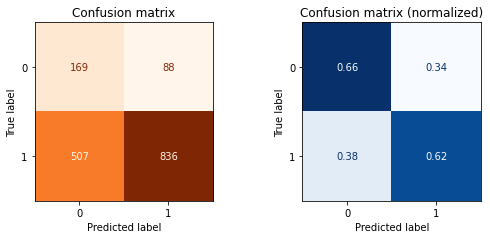

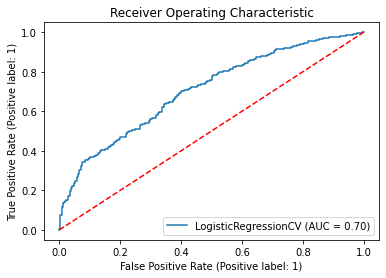

In [51]:
plot_cm_roc()

In [52]:
save_perf('log_reg_cv')

c:\users\david anker\.virtualenvs\mdsi_adsi_feb21_at1-n_gyw-cp\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,name,auc,sens,spec,f1
0,log_reg_cv,0.704987,0.62249,0.65759,0.73754


#### Model interpretation

In [13]:
# Variable importance by permutation
from mlxtend.evaluate import feature_importance_permutation

imp_vals, imp_all = feature_importance_permutation(predict_method = reg.predict,
                                             X = X_val,
                                             y = y_val,
                                             metric = 'accuracy',
                                             num_rounds = 10,
                                             seed = 1)

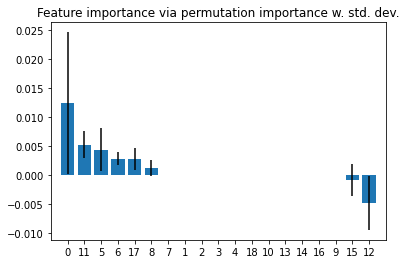

In [14]:
# from user guide

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Feature importance via permutation importance w. std. dev.")
plt.bar(range(X_val.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X_val.shape[1]), indices)
plt.xlim([-1, X_val.shape[1]])
plt.show()

#### Partial Dependence Plot

In [63]:
from sklearn.inspection import plot_partial_dependence
feature_index = X_val[1,]
plot_partial_dependence(reg, 
                        X_val, 
                        features=[feature_index], 
                        n_jobs=3, 
                        grid_resolution=20)

ValueError: Each entry in features must be either an int, a string, or an iterable of size at most 2.

## Test

In [32]:
# Predict target probabilities
test_probs = reg.predict_proba(X_test)[:,1]

In [33]:
# Create dataframe object
test_probs_df = pd.DataFrame(test_probs, columns = ["TARGET_5Yrs"])

# Name 'ID' column
test_probs_df.index.name = "Id"

In [34]:
# Save model predictions on test data to .csv for import into Kaggle
test_probs_df.to_csv("../../reports/David/kaggle_sub.csv")